In [1]:
import matplotlib.pyplot as plt
import pandas as pd
#import modin.pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import gc
from sklearn.metrics import confusion_matrix, roc_curve 
import matplotlib.pyplot as plt
import seaborn as sns
import torch.multiprocessing as mp

#mp.set_start_method('spawn')

pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# df = pd.read_csv("output_adam.csv")
# df_label = pd.read_csv("mirai_labels.csv")
# df["alert"] = df_label
# df.head()

In [2]:
df = pd.read_csv("df_train.csv")

/tmp/ipykernel_26456/2622340693.py:1: DtypeWarning: Columns (24,25,26,27,28,30,38,39,40,41,42,44,46,48,50,51,52,53,55,56,57,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_train.csv")


In [3]:
df.columns

Index(['Unnamed: 0', 'frame.number', 'frame.len', 'frame.time',
       'frame.time_epoch', 'frame.protocols', 'eth.src', 'eth.dst', 'eth.type',
       'ip.src', 'ip.dst', 'ip.len', 'ip.ttl', 'ip.flags', 'ip.frag_offset',
       'ip.proto', 'ip.version', 'ip.dsfield', 'ip.checksum', 'tcp.srcport',
       'tcp.dstport', 'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.flags',
       'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset',
       'tcp.window_size', 'tcp.checksum', 'tcp.stream', 'udp.srcport',
       'udp.dstport', 'udp.length', 'udp.checksum', 'icmp.type', 'icmp.code',
       'icmp.checksum', 'http.request.method', 'http.request.uri',
       'http.request.version', 'http.request.full_uri', 'http.response.code',
       'http.user_agent', 'http.content_length_header', 'http.content_type',
       'http.cookie', 'http.host', 'http.referer', 'http.location',
       'http.authorization', 'http.connection', 'dns.qry.name', 'dns.qry.type',
       'dns.qry.class', 'dns.flags.res

In [3]:
df["frame.time"].iloc[1]

'Aug  9, 2017 10:56:53.367937000 Środkowoeuropejski czas letni'

In [57]:
df["alert"].value_counts()/len(df)

alert
0.0    0.773205
1.0    0.226795
Name: count, dtype: float64

In [3]:
features = ["frame.number", "frame.len", 'frame.time', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'ip.len', 'ip.ttl',
            'tcp.srcport', 'tcp.dstport',
            'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', "alert", "udp.srcport", "udp.dstport"]
df = df[features]
df["frame.len"] /= 65535
df["ip.len"] /= 65535
df["ip.ttl"] /= 255
df["tcp.srcport"] /= 65535
df["tcp.dstport"] /= 65535
df["udp.srcport"] /= 65535
df["udp.dstport"] /= 65535
df["frame.time"] = df["frame.time"].str.replace(" Środkowoeuropejski czas letni", "")
df["frame.time"] = df["frame.time"].str.replace(" Środkowoeuropejski czas stand.", "")
df["frame.time"] = df["frame.time"].str.replace(" CEST", "")
df["frame.time"] = pd.to_datetime(df["frame.time"])
df["second_sin"] = np.sin(2 * np.pi * df["frame.time"].dt.second / 60)
df["second_cos"] = np.cos(2 * np.pi * df["frame.time"].dt.second / 60)
df["ms_sin"] = np.sin(2 * np.pi * df["frame.time"].dt.microsecond / 1000000)
df["ms_cos"] = np.cos(2 * np.pi * df["frame.time"].dt.microsecond / 1000000)
df = df.fillna(0)  # only tcp is left
df[['tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset']] = df[['tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset']].astype(int)
df = df.drop(columns=["frame.time"])

In [4]:
from multiprocessing import Pool
from tqdm import trange

class Ordinalizer:
    def __init__(self, df):
        self.df = df
    def ordinalize_packets(self, packet_data, column="ip"):
        src_col = f"{column}.src"
        dst_col = f"{column}.dst"
        if 'frame.number' not in packet_data.columns or src_col not in packet_data.columns or dst_col not in packet_data.columns:
            raise ValueError("DataFrame must contain 'frame.number' and  columns")
    
        out_src = packet_data.reset_index().groupby([src_col])['index'].min()
        out_dst = packet_data.reset_index().groupby([dst_col])['index'].min() + 0.5
        out = pd.concat([out_src, out_dst], axis=0).sort_values()
        out = out[~out.index.duplicated(keep='first')]
        out.iloc[:] = out.reset_index(name="ip").index
        out = out.astype(int)
        mappings = out.to_dict()
        return mappings    
    def ordinal_ip(self, i):
        return self.ordinalize_packets(self.df[i:i+128], "ip")
    def ordinal_eth(self, i):
        return self.ordinalize_packets(self.df[i:i+128], "eth")

    def ordinalize(self):
        p = Pool(processes=6)
        mappings_ip = p.map(self.ordinal_ip, trange(len(self.df) - 128))
        mappings_eth = p.map(self.ordinal_eth, trange(len(self.df) - 128))
        p.close()
        p.join()
        del p
        return  mappings_eth, mappings_ip
    
ord = Ordinalizer(df)
mappings_eth, mappings_ip = ord.ordinalize()



100%|██████████| 20747468/20747468 [38:05<00:00, 9077.39it/s] 


In [5]:
import pickle
pickle.dump(mappings_ip, open('ip_mappings_train', 'wb'))
pickle.dump(mappings_eth, open('eth_mappings_train', 'wb'))

In [5]:
df.info()
df.to_parquet("df_processed.parquet")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20747596 entries, 0 to 20747595
Data columns (total 20 columns):
 #   Column           Dtype  
---  ------           -----  
 0   frame.number     float64
 1   frame.len        float64
 2   eth.src          int64  
 3   eth.dst          int64  
 4   ip.src           int64  
 5   ip.dst           int64  
 6   ip.len           float64
 7   ip.ttl           float64
 8   tcp.srcport      float64
 9   tcp.dstport      float64
 10  tcp.flags.ack    int64  
 11  tcp.flags.fin    int64  
 12  tcp.flags.reset  int64  
 13  alert            float64
 14  udp.srcport      float64
 15  udp.dstport      float64
 16  second_sin       float64
 17  second_cos       float64
 18  ms_sin           float64
 19  ms_cos           float64
dtypes: float64(13), int64(7)
memory usage: 3.1 GB


In [2]:
from torch.utils.data import Dataset


import pyarrow.parquet as pq
import pyarrow as pa
import pickle
from multiprocessing import Manager


class NetworkDataset(Dataset):
    def __init__(self, data, window=128, mapping_ip=None, mapping_eth=None):
        
        self.data = pq.ParquetFile(data)
        self.window = window
        manager = Manager()
        self.row_group_sizes = [self.data.metadata.row_group(i).num_rows 
                                for i in range(self.data.num_row_groups)]
        self.cum_sizes = np.cumsum(self.row_group_sizes)
        self.total_rows = self.cum_sizes[-1]
        self.mappings_ip = manager.list(pickle.load(open(mapping_ip, "rb")))
        self.mappings_eth = manager.list(pickle.load(open(mapping_eth, "rb")))
        self.table = self.data.read()
        
    
    def __getitem__(self, index):
        packets = self.table.slice(index, length=self.window)
        
        cols = packets.column_names
        exclude = {'alert', 'frame.number', 'ip.src', 'ip.dst', 'eth.src', 'eth.dst'}
        feature_cols = [c for c in cols if c not in exclude]
        
        def to_numpy(col):
            return packets.column(col).combine_chunks().to_numpy(zero_copy_only=True)

        feature_values = np.column_stack([
            np.nan_to_num(to_numpy(c).astype(np.float32)) for c in feature_cols
        ])
        
        labels = to_numpy('alert').astype(np.float32)
        def fast_map(values, mapping):
            py_values = values.to_pylist()
            return np.fromiter((mapping.get(v, 0) for v in py_values), dtype=np.int32)
    
        mappings_eth = self.mappings_eth[index]
        mappings_ip = self.mappings_ip[index]
        eth_src = fast_map(packets.column('eth.src'), mappings_eth)[:, np.newaxis]
        eth_dst = fast_map(packets.column('eth.dst'), mappings_eth)[:, np.newaxis]
        ip_src = fast_map(packets.column('ip.src'), mappings_ip)[:, np.newaxis]
        ip_dst = fast_map(packets.column('ip.dst'), mappings_ip)[:, np.newaxis]

    
        return np.nan_to_num(np.concatenate([eth_src, eth_dst], axis=1), nan=0).astype(int), np.nan_to_num(np.concatenate([ip_src, ip_dst], axis=1), nan=0).astype(int), feature_values, labels
                         

    def __len__(self):
        return self.total_rows - self.window

In [3]:
from torch.nn.utils.parametrizations import weight_norm


class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size, dilation):
        super(ResBlock, self).__init__()
        self.conv1 = weight_norm(
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, dilation=dilation))
        self.conv2 = weight_norm(
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, dilation=dilation))
        self.pad = nn.ZeroPad1d((kernel_size - 1) // 2 * dilation)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        t = self.pad(x)
        t = F.relu(self.conv1(t))
        t = self.pad(t)
        t = F.relu(self.conv2(t))
        return self.dropout(t) + x

In [4]:
class TCN(nn.Module):
    def __init__(self, channels, kernel_size, blocks):
        super(TCN, self).__init__()
        self.blocks = nn.Sequential(*[ResBlock(channels, kernel_size, 2**i) for i in range(blocks)])
        
    def forward(self, x):
        return self.blocks(x)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.eth_embed = nn.Embedding(128, 32)
        self.ip_embed = nn.Embedding(128, 32)
        self.total_embed = nn.Linear(142, 64)
        self.conv = TCN(128, 5, 5)
        self.projection = nn.Linear(64, 1)

    def forward(self, eth, ip, packet):
        B = packet.size(0)
        L = packet.size(1)
        eth = self.eth_embed(eth).view(B, L, -1)
        ip = self.ip_embed(ip).view(B, L, -1)
        pk_embed = self.total_embed(torch.cat((eth, ip, packet), dim=-1))
        processed = nn.functional.relu(self.conv(pk_embed))
        preds = self.projection(processed).squeeze(-1)
        return preds

In [ ]:
gc.collect()

In [6]:
dataset = NetworkDataset("df_processed.parquet", 128, 'ip_mappings_train', 'eth_mappings_train') # preparation of dataset

In [39]:
dataset[0][0].shape

array([[ 0.02310216,  0.02288853,  0.2509804 , ...,  0.7431448 ,
         0.73834   , -0.6744287 ],
       [ 0.02310216,  0.02288853,  0.2509804 , ...,  0.7431448 ,
         0.7377804 , -0.67504084],
       [ 0.02310216,  0.02288853,  0.2509804 , ...,  0.7431448 ,
         0.7368593 , -0.67604613],
       ...,
       [ 0.02310216,  0.02288853,  0.2509804 , ...,  0.7431448 ,
         0.3529223 , -0.9356526 ],
       [ 0.02310216,  0.02288853,  0.2509804 , ...,  0.7431448 ,
         0.35180506, -0.9360733 ],
       [ 0.00318914,  0.00297551,  0.2509804 , ...,  0.7431448 ,
         0.35128742, -0.9362677 ]], dtype=float32)

In [38]:
dataset[0][0].shape

(128, 2)

In [7]:
dataset_val = NetworkDataset("df_eval_proc.parquet", 128, 'ip_mappings_val1', 'eth_mappings_val1') #

In [23]:
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from accelerate import Accelerator

accelerator = Accelerator(mixed_precision="bf16")
model = Model()
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True, num_workers=32,
                        persistent_workers=True)
test_loader = DataLoader(dataset_val, batch_size=512, shuffle=True, drop_last=True, num_workers=24, pin_memory=True)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = LinearLR(optimizer, total_iters=8, start_factor=1, end_factor=0.2)
loss_fn = nn.BCEWithLogitsLoss()

model, dataloader, optimizer, scheduler = accelerator.prepare(model, dataloader, optimizer, scheduler)

for epoch in range(8):
    count = 0
    total = 0
    model.train()
    for eth, ip, pkt, labels in tqdm(dataloader):
        optimizer.zero_grad()
        pkt = model(eth, ip, pkt)
        loss = loss_fn(pkt, labels)
        count += 1
        total += loss.item()
        accelerator.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
    scheduler.step()
    model.eval()
    acc = 0
    count_t = 0
    cm = np.zeros((2, 2))
    for eth, ip, pkt, labels in tqdm(test_loader):
        count_t += 512*128
        pred = F.sigmoid(model(ip.cuda(), eth.cuda(), pkt.cuda()))
        acc +=  (labels.cuda() == (pred > 0.5)).sum()
        cm += confusion_matrix(labels.flatten().cpu(), pred.flatten().cpu().detach() > 0.5)
    print(f"test {acc/count_t}")
    print("Epoch {} Loss {}".format(epoch, total / count))
    print(scheduler.get_last_lr())

 50%|████▉     | 40195/81044 [07:48<07:55, 85.88it/s] 


KeyboardInterrupt: 

In [51]:
print(acc)

tensor(15858893, device='cuda:0')


In [40]:
torch.save(model.state_dict(), "mdl")

In [41]:
df_val = pd.read_csv("df_val.csv")

/tmp/ipykernel_26456/3364097189.py:1: DtypeWarning: Columns (23,24,25,26,27,29,37,38,39,40,41,43,47,49,52,54,55,56,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df_val = pd.read_csv("df_val.csv")


In [42]:
df_val = df_val[features]
df_val["frame.len"] /= 65535
df_val["ip.len"] /= 65535
df_val["ip.ttl"] /= 255
df_val["tcp.srcport"] /= 65535
df_val["tcp.dstport"] /= 65535
df_val["udp.srcport"] /= 65535
df_val["udp.dstport"] /= 65535
df_val["frame.time"] = df_val["frame.time"].str.replace(" Środkowoeuropejski czas letni", "")#mój PCAP był po POlsku Pudzian byłby dumny :peepoGlad# CEST
df_val["frame.time"] = df_val["frame.time"].str.replace(" Środkowoeuropejski czas stand.", "")
df_val["frame.time"] = df_val["frame.time"].str.replace(" CEST", "")
df_val["frame.time"] = pd.to_datetime(df_val["frame.time"])
df_val["second_sin"] = np.sin(2 * np.pi * df_val["frame.time"].dt.second / 60 + 0.5)
df_val["second_cos"] = np.cos(2 * np.pi * df_val["frame.time"].dt.second / 60 + 0.5)
df_val["ms_sin"] = np.sin(2 * np.pi * df_val["frame.time"].dt.microsecond / 1000000 +1)
df_val["ms_cos"] = np.cos(2 * np.pi * df_val["frame.time"].dt.microsecond / 1000000 + 1)
df_val = df_val.fillna(0)  # only tcp is left
df_val[['tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset']] = df_val[['tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset']].astype(int)
df_val = df_val.drop(columns=["frame.time"])

In [67]:
df_val.to_parquet("df_eval_proc.parquet")

In [43]:
ord = Ordinalizer(df_val)
mappings_ip, mappings_eth = ord.ordinalize()

100%|██████████| 269872/269872 [00:32<00:00, 8349.49it/s] 


In [44]:
import pickle
pickle.dump(mappings_ip, open('ip_mappings_val1', 'wb'))
pickle.dump(mappings_eth, open('eth_mappings_val1', 'wb'))

In [29]:
model.eval()
ip, eth, pkt, labels = dataset_val[0]
ip = torch.from_numpy(ip).cuda().unsqueeze(0)
eth = torch.from_numpy(eth).cuda().unsqueeze(0)
pkt = torch.from_numpy(pkt).cuda().unsqueeze(0)
labels = torch.from_numpy(labels).cuda().unsqueeze(0)

pred = F.sigmoid(model(ip, eth, pkt))
print(pred > 0.5)
(labels == (pred > 0.5)).sum()/128


tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]], device='cuda:0')


tensor(0.9609, device='cuda:0')

In [32]:
test_loader = DataLoader(dataset_val, batch_size=512, shuffle=True, drop_last=True, num_workers=24, pin_memory=True)

model.eval()
acc = 0
count = 0
cm = np.zeros((2, 2))
for eth, ip, pkt, labels in tqdm(test_loader):
    count += 512*128
    pred = F.sigmoid(model(ip.cuda(), eth.cuda(), pkt.cuda()))
    acc +=  (labels.cuda() == (pred > 0.4)).sum()
    cm += confusion_matrix(labels.flatten().cpu(), pred.flatten().cpu().detach() > 0.4)
print(acc/count)

100%|██████████| 527/527 [00:16<00:00, 32.17it/s]

tensor(0.6079, device='cuda:0')


In [57]:
pred.shape

torch.Size([1, 128])

In [45]:
pred = pred.reshape(-1, 1)
labels =  labels.reshape(-1, 1)

In [52]:
loss_fn(pred, labels)

tensor(3.3650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

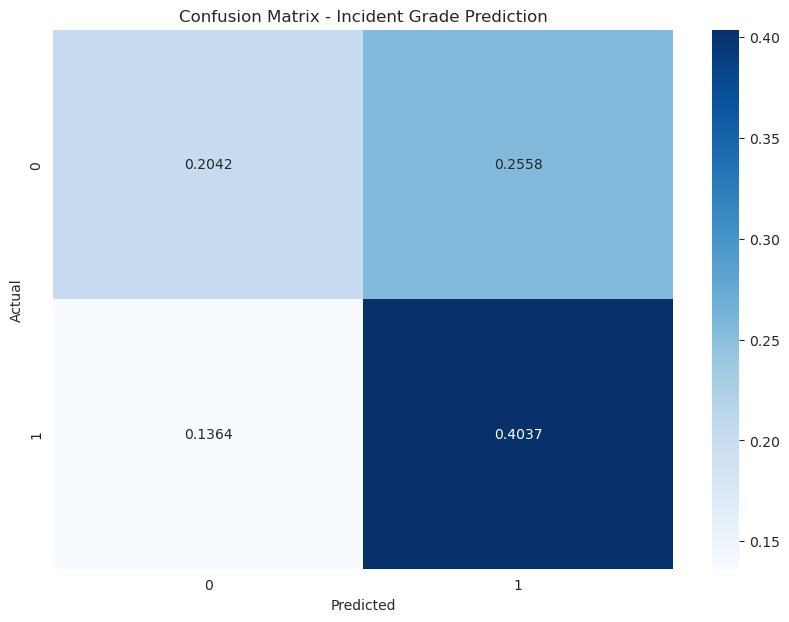

In [33]:
# Plot with Seaborn
# without time shift
plt.figure(figsize=(10, 7))
sns.heatmap(cm/count, annot=True, fmt='.4f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Incident Grade Prediction')
plt.show()

/tmp/ipykernel_26456/1251064625.py:4: RuntimeWarning: divide by zero encountered in divide
  sns.heatmap(cm/count, annot=True, fmt='.4f', cmap='Blues')


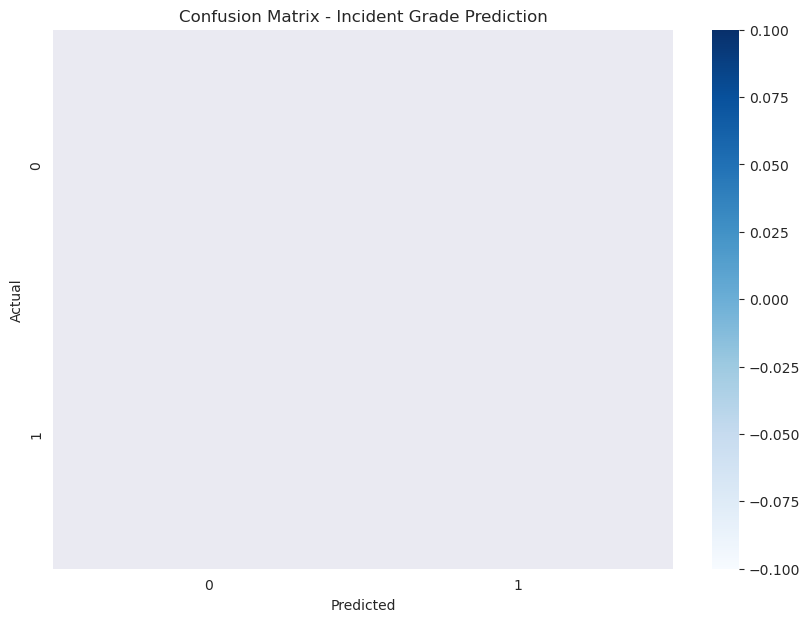

In [53]:
# Plot with Seaborn
# with time shift
plt.figure(figsize=(10, 7))
sns.heatmap(cm/count, annot=True, fmt='.4f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Incident Grade Prediction')
plt.show()

KeyboardInterrupt: 

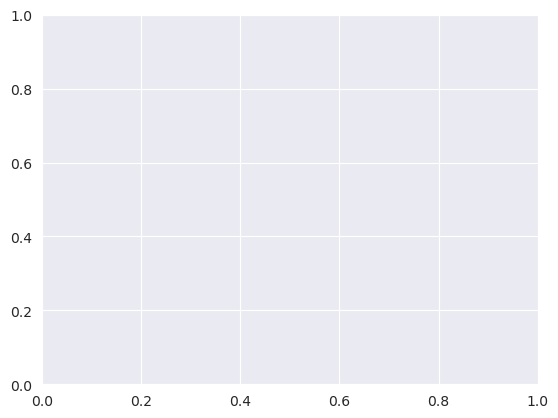

In [75]:
sns.barplot(df["alert"])

In [52]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(labels.cpu(), pred.cpu())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: multilabel-indicator format is not supported